In [9]:
import os
import pandas as pd

# Step 1: Define paths
image_dir = "./celeba_Orig/images/"
attributes_file = "./celeba_Orig/list_attr_celeba.txt"

# Step 2: Load the attribute file
attributes = pd.read_csv(attributes_file, delim_whitespace=True, skiprows=1)
attributes.reset_index(inplace=True)  # Reset index to access the filename column
attributes.rename(columns={'index': 'image_name'}, inplace=True)

# Step 3: Filter for Specific Attributes
# Keep only the relevant attributes
attributes = attributes[['image_name', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']]

# Step 4: Select a Subset of Images (2/10 of the dataset)
subset_fraction = 0.2
subset_size = int(len(attributes) * subset_fraction)
attributes = attributes.sample(n=subset_size, random_state=42).reset_index(drop=True)

# Step 5: Define train, test, valid splits
# Calculate split sizes based on the subset
num_train = int(0.8 * subset_size)  # 80% for training
num_valid = int(0.1 * subset_size)  # 10% for validation

train_data = attributes[:num_train]
valid_data = attributes[num_train:num_train + num_valid]
test_data = attributes[num_train + num_valid:]

# Step 6: Create a function to load and preprocess images
def load_image(img_name, label):
    # Ensure img_name is a string by decoding the Tensor
    img_name = tf.strings.join([image_dir, img_name])
    img = tf.io.read_file(img_name)
    img = tf.image.decode_jpeg(img, channels=3)  # Decode JPEG
    # Crop the image to 178x178 from the center
    img = tf.image.resize_with_crop_or_pad(img, target_height=178, target_width=178)
    
    # Resize to 128x128
    img = tf.image.resize(img, [128, 128])    
    img = img / 255.0  # Normalize to [0, 1]
    return img, label


# Step 7: Create a function to generate a TensorFlow dataset
def create_dataset(dataframe):
    image_names = dataframe['image_name'].values
    labels = dataframe.iloc[:, 1:].values  # All columns except 'image_name'
    
    # Convert labels from -1,1 to 0,1 (for binary classification)
    labels = (labels + 1) // 2  # Convert -1, 1 to 0, 1
    
    # Labels are already binary (0 or 1), no need for one-hot encoding
    dataset = tf.data.Dataset.from_tensor_slices((image_names, labels))
    dataset = dataset.map(lambda x, y: load_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.repeat()  # Add this line to repeat the dataset indefinitely
    return dataset

# Step 8: Create train, test, and validation datasets
raw_train = create_dataset(train_data).shuffle(1000).batch(128).prefetch(tf.data.AUTOTUNE)
raw_valid = create_dataset(valid_data).batch(128).prefetch(tf.data.AUTOTUNE)
raw_test = create_dataset(test_data).batch(128).prefetch(tf.data.AUTOTUNE)

# Step 9: Verify the dataset
for images, labels in raw_train.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")


C:\Users\Gordts-De Laender\AppData\Local\Temp\ipykernel_2032\4292149607.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  attributes = pd.read_csv(attributes_file, delim_whitespace=True, skiprows=1)


Image batch shape: (128, 128, 128, 3)
Label batch shape: (128, 5)


In [15]:
#base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
import tensorflow as tf
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)

base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(5, activation='sigmoid')  # Use sigmoid for multi-label classification

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle

# Define validation steps (can be adjusted as needed)
validation_steps = 34 #Number of validation images /Batch size
initial_epochs = 40
steps_per_epoch = 275

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitor validation loss
    patience=3,               # Patience of 3 epochs
    restore_best_weights=True # Restore best weights
)

# Define learning rate scheduler callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',      # Monitor validation loss
    factor=0.5,              # Reduce learning rate by 50%
    patience=2,              # Wait for 2 epochs without improvement before reducing
    min_lr=1e-6              # Minimum learning rate to avoid too small learning rate
)

# Evaluate the model on the validation dataset
loss0, accuracy0 = model.evaluate(raw_valid, steps=validation_steps)

# Train the model with both callbacks
history = model.fit(
    raw_train,
    epochs=initial_epochs,
    steps_per_epoch=steps_per_epoch, 
    validation_steps=validation_steps,
    validation_data=raw_valid,
    callbacks=[early_stopping, lr_scheduler]  # Include both callbacks
)

# Save the model
model.save('my_model.h5')  # Saves the model in HDF5 format

# Save history to a file
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

34/34 [==============================] - 12s 337ms/step - loss: 0.8115 - binary_accuracy: 0.4531
Epoch 1/40
275/275 [==============================] - 113s 399ms/step - loss: 0.4767 - binary_accuracy: 0.7834 - val_loss: 0.3927 - val_binary_accuracy: 0.8261 - lr: 1.0000e-04
Epoch 2/40
275/275 [==============================] - 108s 394ms/step - loss: 0.3740 - binary_accuracy: 0.8343 - val_loss: 0.3531 - val_binary_accuracy: 0.8458 - lr: 1.0000e-04
Epoch 3/40
275/275 [==============================] - 107s 391ms/step - loss: 0.3475 - binary_accuracy: 0.8464 - val_loss: 0.3364 - val_binary_accuracy: 0.8525 - lr: 1.0000e-04
Epoch 4/40
275/275 [==============================] - 108s 392ms/step - loss: 0.3342 - binary_accuracy: 0.8530 - val_loss: 0.3268 - val_binary_accuracy: 0.8573 - lr: 1.0000e-04
Epoch 5/40
275/275 [==============================] - 111s 403ms/step - loss: 0.3254 - binary_accuracy: 0.8568 - val_loss: 0.3207 - val_binary_accuracy: 0.8597 - lr: 1.0000e-04
Epoch 6/40
275/275

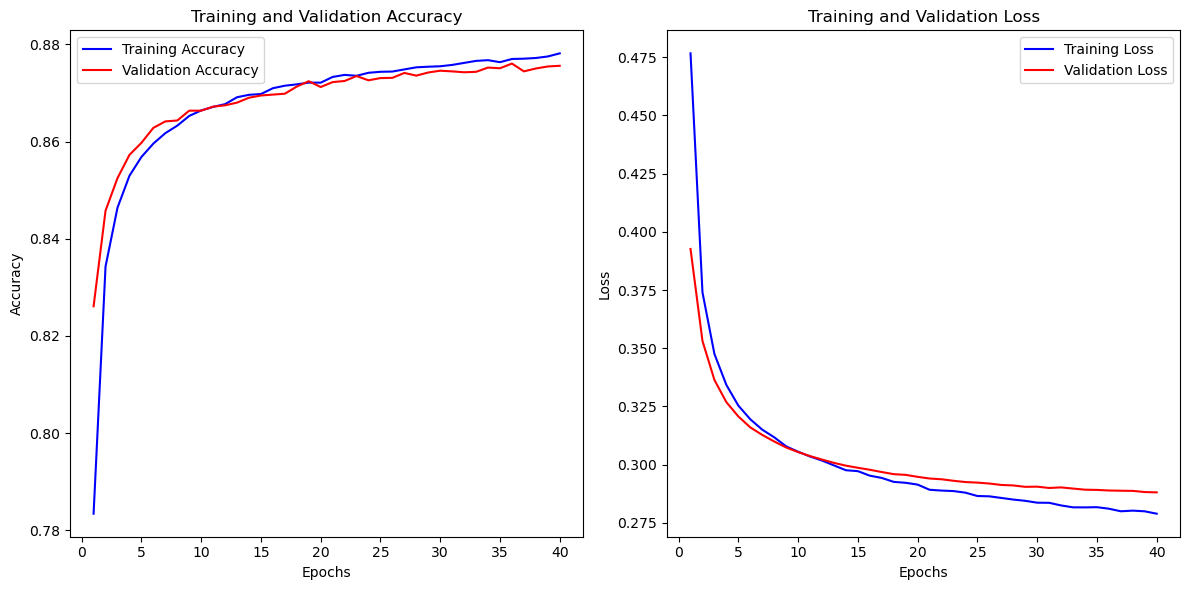

In [1]:
import matplotlib.pyplot as plt
import pickle

# Load the history dictionary
with open('training_history.pkl', 'rb') as f:
    history_dict = pickle.load(f)

# Extract the loss and accuracy history
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Define the number of epochs
epochs = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 32ms/step


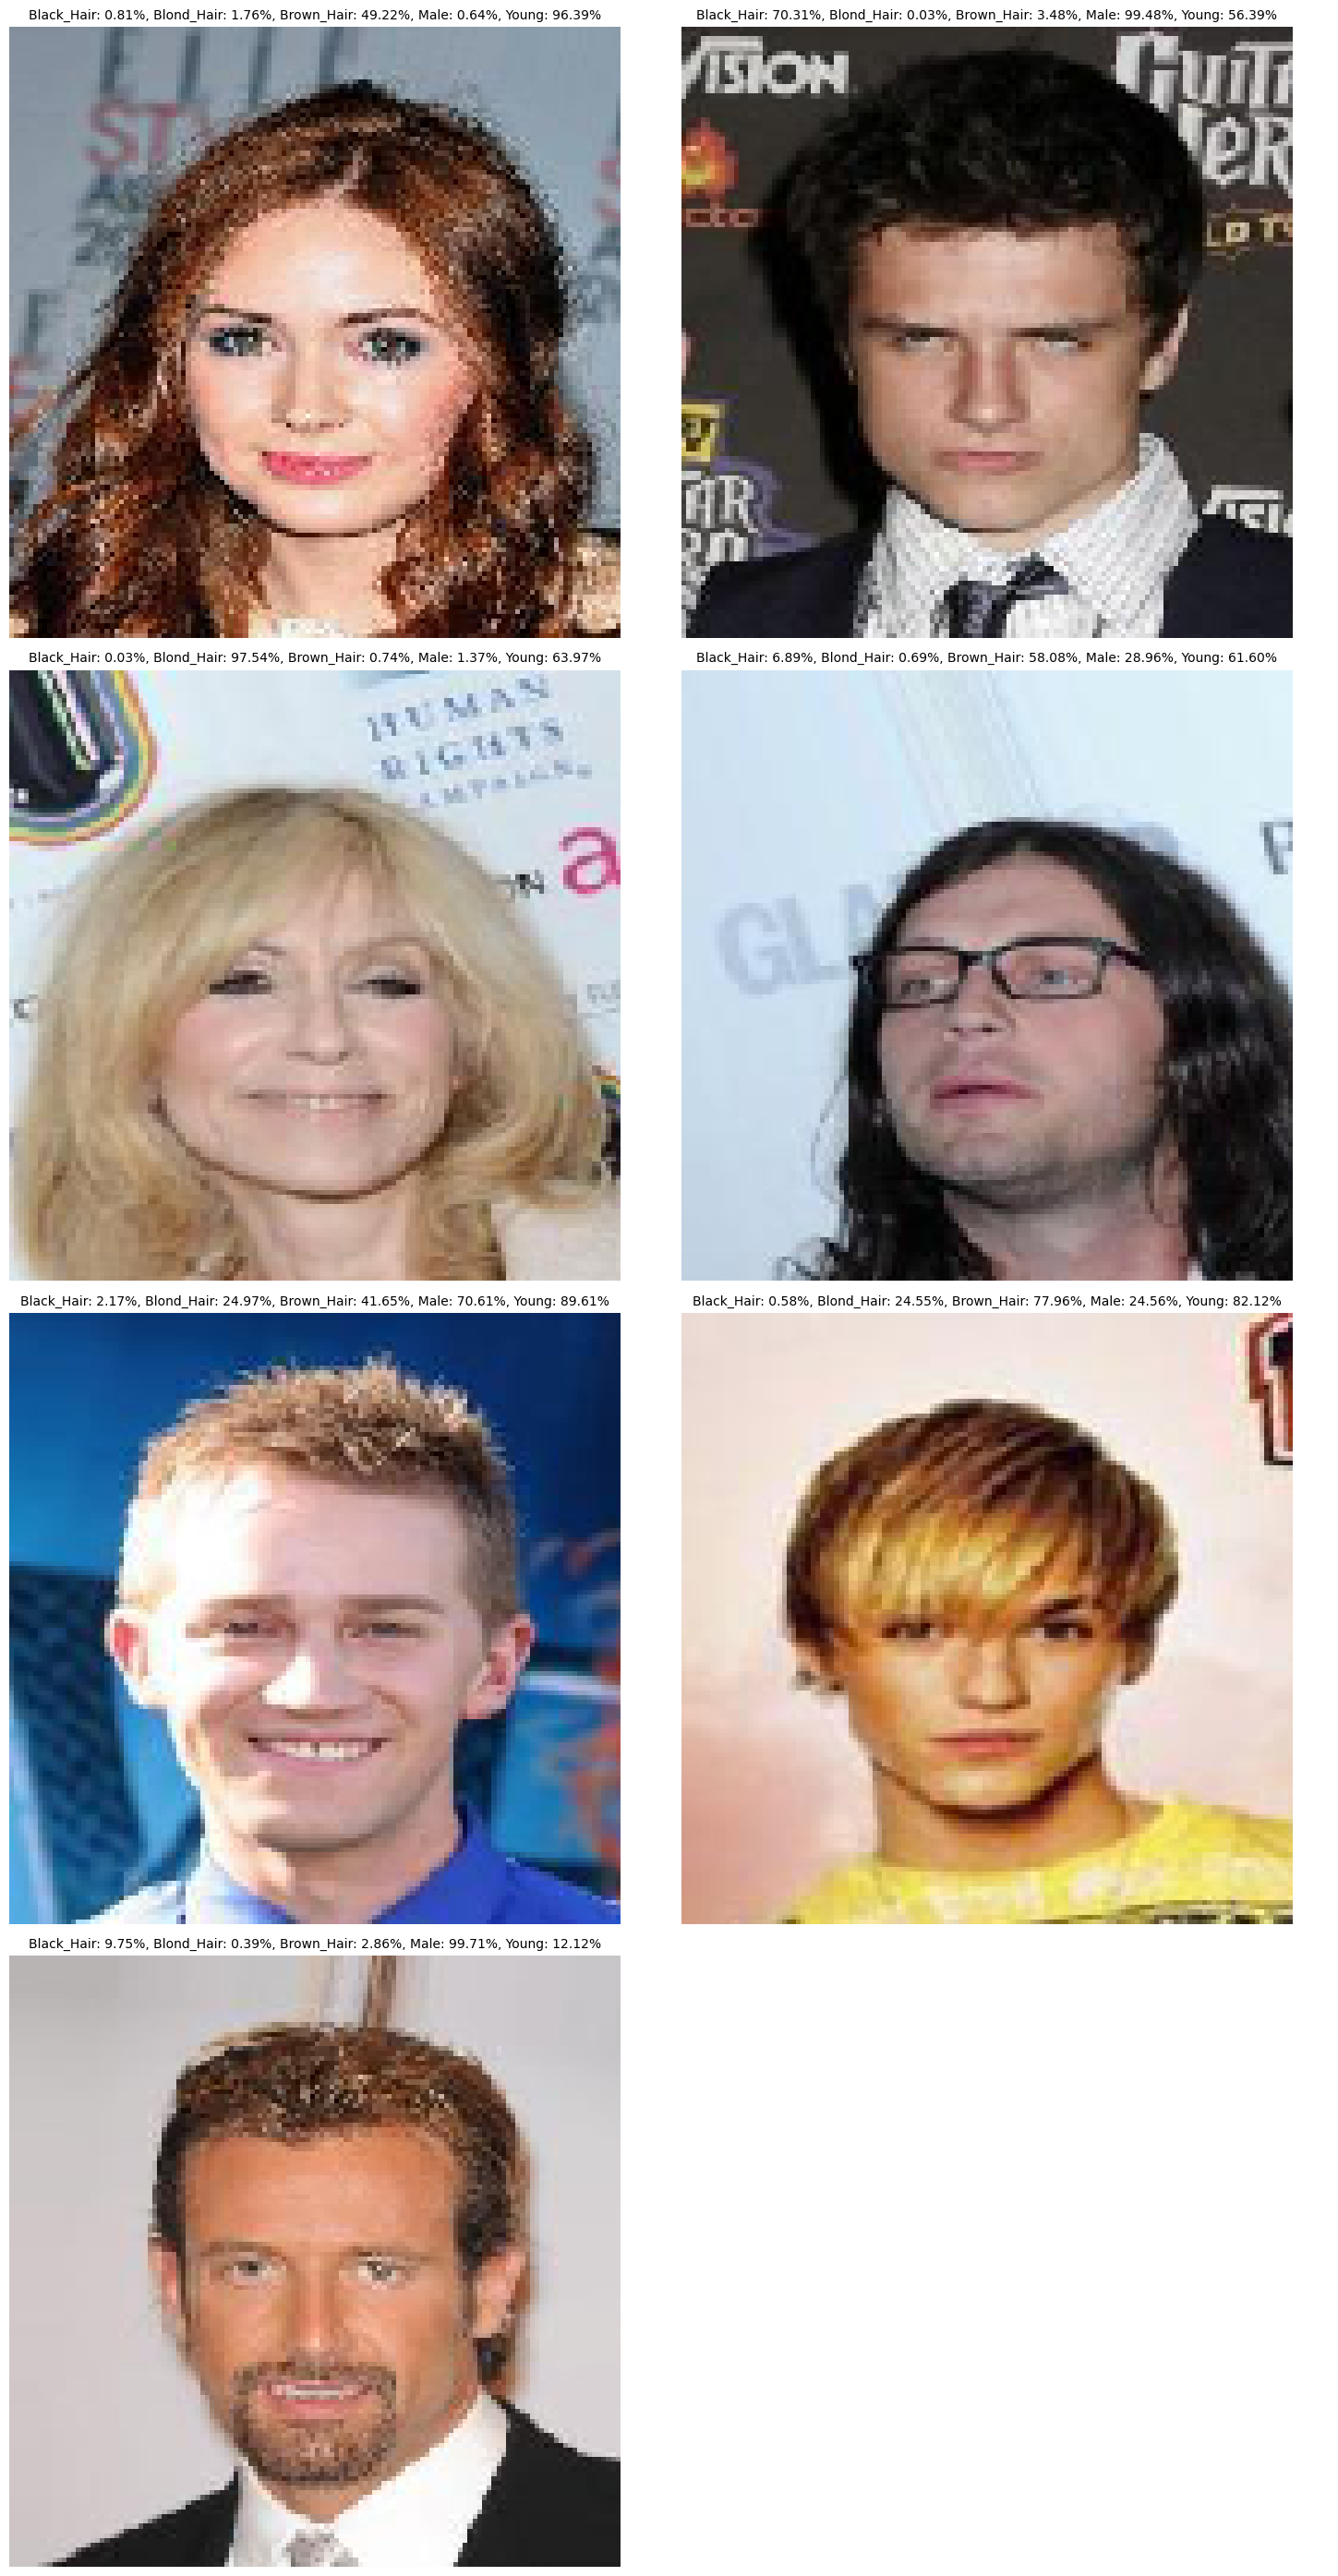

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image

# Load the saved model
model = tf.keras.models.load_model('my_model.h5')

# Define a function to preprocess the input image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))  # Resize the image
    img_array = image.img_to_array(img)  # Convert the image to a numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return img_array

# Define categories
categories = ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']

# Directory containing images
image_directory = '.'  # Replace with the path to your image directory
image_paths = [os.path.join(image_directory, fname) for fname in os.listdir(image_directory) if fname.endswith(('.png', '.jpg', '.jpeg'))]

# Set up grid size with 2 images per row (adjusting for the number of images)
images_per_row = 2
grid_size = (len(image_paths) // images_per_row) + (1 if len(image_paths) % images_per_row != 0 else 0)
fig, axes = plt.subplots(grid_size, images_per_row, figsize=(15, grid_size * 7))
axes = axes.flatten()  # Flatten axes for easy iteration

# Define threshold to classify the predictions as Yes/No
threshold = 0.5

# Iterate through images and display predictions
for i, ax in enumerate(axes):
    if i < len(image_paths):
        img_path = image_paths[i]
        
        # Preprocess and predict
        img = preprocess_image(img_path)
        predictions = model.predict(img)  # Get raw model predictions
        
        # Display image
        img_display = image.load_img(img_path, target_size=(128, 128))
        ax.imshow(img_display)
        ax.axis('off')  # Hide axis
        
        # Display categories with prediction percentages
        prediction_text = ", ".join([f"{cat}: {predictions[0][j]*100:.2f}%" for j, cat in enumerate(categories)])
        
        # Convert predictions to Yes/No based on threshold
        #prediction_text = ", ".join([f"{cat}: {'Yes' if predictions[0][j] >= threshold else 'No'}" for j, cat in enumerate(categories)])
        ax.set_title(prediction_text, fontsize=10)
    else:
        ax.axis('off')  # Hide any unused grid cells

# Adjust layout and display the grid
plt.tight_layout()
plt.show()


In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle

# Load the pre-trained model from the saved file
model = tf.keras.models.load_model('my_model.h5')  # Load the previously saved model

# Define validation steps (can be adjusted as needed)
validation_steps = 34 #Number of validation images /Batch size
initial_epochs = 40
steps_per_epoch = 275

# Set the base model to be trainable
base_model = model.layers[0]  # The first layer should be the MobileNetV2 base model
base_model.trainable = True

# Print the number of layers in the base model to understand where to unfreeze
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards (for example, from the 100th layer)
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model after unfreezing some layers
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),  # Use 'from_logits=False' as per the previous changes
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001),  # Lower the learning rate for fine-tuning (you can adjust this)
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

# Load the history dictionary
with open('training_history.pkl', 'rb') as f:
    history_dict = pickle.load(f)

initial_epoch = len(history_dict['loss'])

# Define the number of epochs for fine-tuning
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs  # Total epochs include the initial training and fine-tuning

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitor validation loss
    patience=3,               # Patience of 3 epochs
    restore_best_weights=True # Restore best weights
)

# Define learning rate scheduler callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',      # Monitor validation loss
    factor=0.5,              # Reduce learning rate by 50%
    patience=2,              # Wait for 2 epochs without improvement before reducing
    min_lr=1e-6              # Minimum learning rate to avoid too small learning rate
)

# Evaluate the model on the validation dataset
loss0, accuracy0 = model.evaluate(raw_valid, steps=validation_steps)

# Fine-tune the model
history_fine = model.fit(
    raw_train,  # Training dataset
    epochs=total_epochs,
    initial_epoch=initial_epoch,  # Continue from the last epoch of initial training
    validation_data=raw_valid,  # Validation dataset
    steps_per_epoch=steps_per_epoch,  # Steps per epoch during fine-tuning
    validation_steps=validation_steps,  # Validation steps
    callbacks=[early_stopping, lr_scheduler]  # You can use callbacks again if necessary
)

# Save the fine-tuned model
model.save('my_model_finetuned.h5')  # Saves the fine-tuned model in HDF5 format

# Save history of fine-tuning to a file
with open('training_history_fine.pkl', 'wb') as f:
    pickle.dump(history_fine.history, f)


Number of layers in the base model:  154
34/34 [==============================] - 12s 335ms/step - loss: 0.2881 - binary_accuracy: 0.8756
Epoch 41/50
275/275 [==============================] - 151s 529ms/step - loss: 0.3889 - binary_accuracy: 0.8433 - val_loss: 0.3540 - val_binary_accuracy: 0.8478 - lr: 1.0000e-05
Epoch 42/50
275/275 [==============================] - 147s 534ms/step - loss: 0.2886 - binary_accuracy: 0.8760 - val_loss: 0.3526 - val_binary_accuracy: 0.8533 - lr: 1.0000e-05
Epoch 43/50
275/275 [==============================] - 145s 528ms/step - loss: 0.2598 - binary_accuracy: 0.8877 - val_loss: 0.3330 - val_binary_accuracy: 0.8621 - lr: 1.0000e-05
Epoch 44/50
275/275 [==============================] - 146s 530ms/step - loss: 0.2410 - binary_accuracy: 0.8962 - val_loss: 0.3117 - val_binary_accuracy: 0.8682 - lr: 1.0000e-05
Epoch 45/50
275/275 [==============================] - 145s 529ms/step - loss: 0.2238 - binary_accuracy: 0.9045 - val_loss: 0.3013 - val_binary_accura

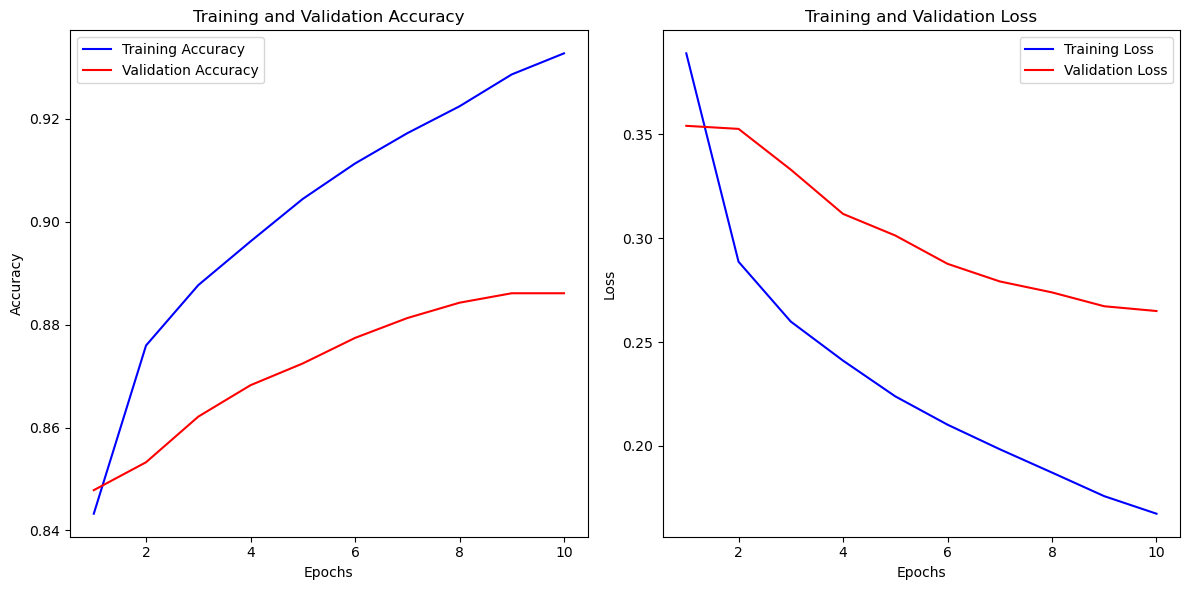

In [16]:
import matplotlib.pyplot as plt
import pickle

# Load the history dictionary
with open('training_history_fine.pkl', 'rb') as f:
    history_dict = pickle.load(f)

# Extract the loss and accuracy history
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Define the number of epochs
epochs = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 35ms/step


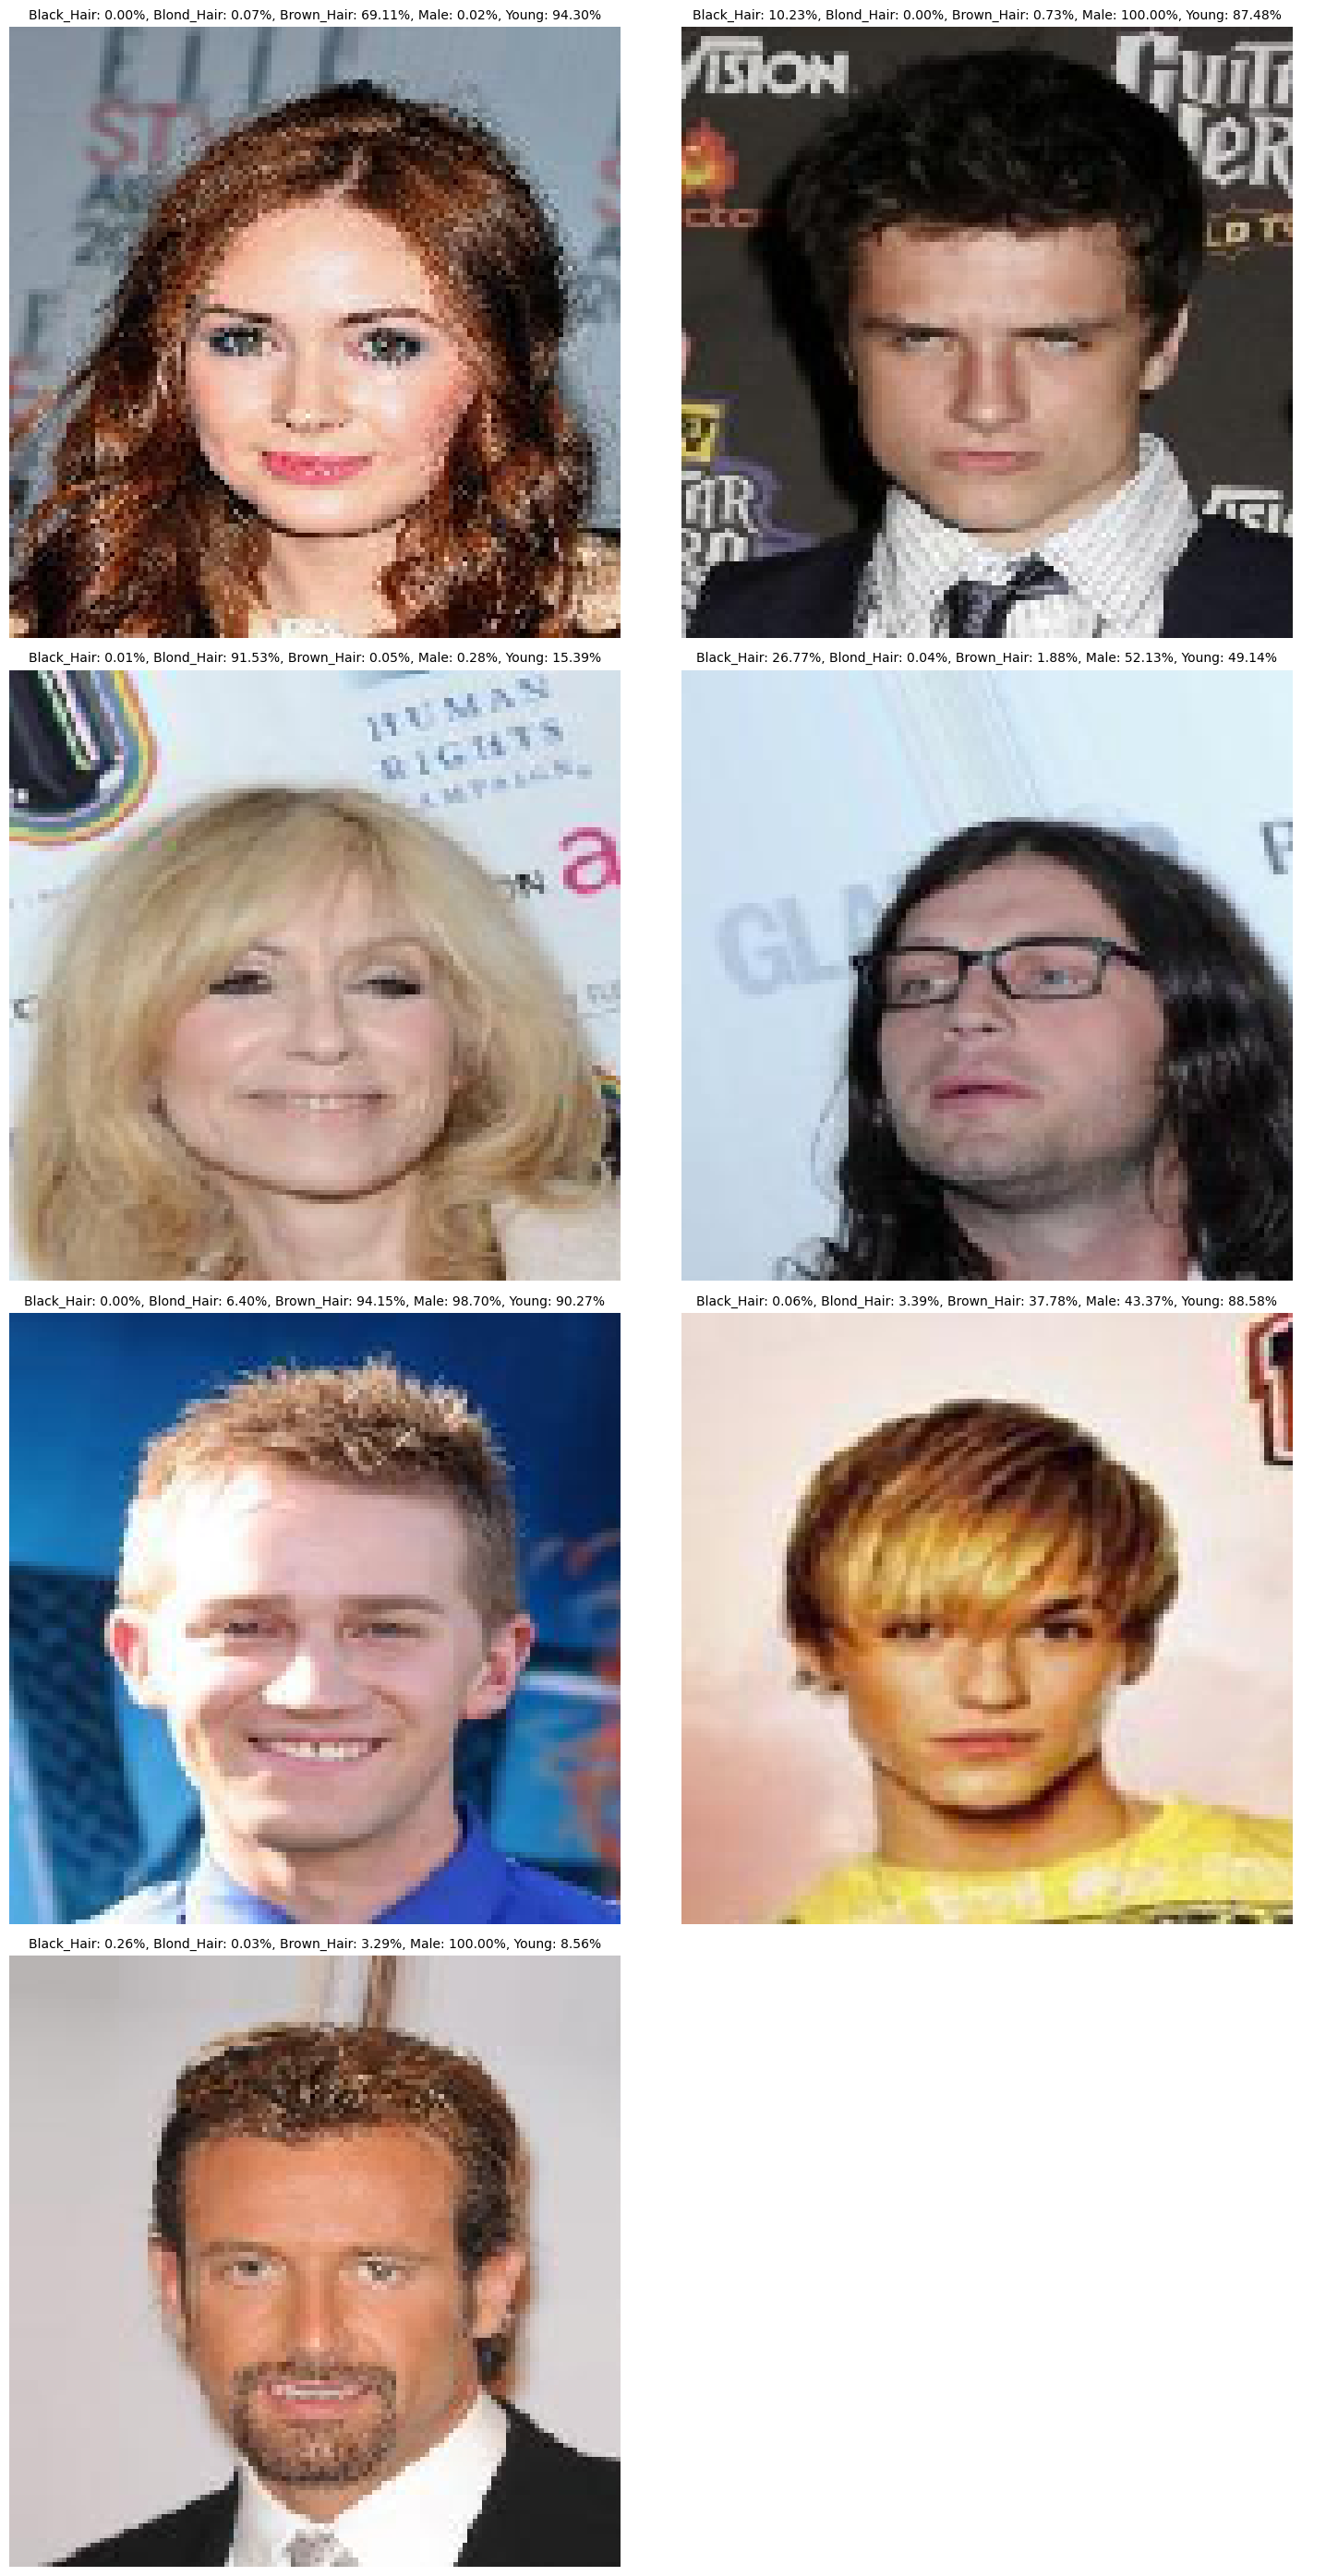

In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image

# Load the saved model
model = tf.keras.models.load_model('my_model_finetuned.h5')

# Define a function to preprocess the input image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))  # Resize the image
    img_array = image.img_to_array(img)  # Convert the image to a numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return img_array

# Define categories
categories = ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']

# Directory containing images
image_directory = '.'  # Replace with the path to your image directory
image_paths = [os.path.join(image_directory, fname) for fname in os.listdir(image_directory) if fname.endswith(('.png', '.jpg', '.jpeg'))]

# Set up grid size with 2 images per row (adjusting for the number of images)
images_per_row = 2
grid_size = (len(image_paths) // images_per_row) + (1 if len(image_paths) % images_per_row != 0 else 0)
fig, axes = plt.subplots(grid_size, images_per_row, figsize=(15, grid_size * 7))
axes = axes.flatten()  # Flatten axes for easy iteration

# Define threshold to classify the predictions as Yes/No
threshold = 0.5

# Iterate through images and display predictions
for i, ax in enumerate(axes):
    if i < len(image_paths):
        img_path = image_paths[i]
        
        # Preprocess and predict
        img = preprocess_image(img_path)
        predictions = model.predict(img)  # Get raw model predictions
        
        # Display image
        img_display = image.load_img(img_path, target_size=(128, 128))
        ax.imshow(img_display)
        ax.axis('off')  # Hide axis
        
        # Display categories with prediction percentages
        prediction_text = ", ".join([f"{cat}: {predictions[0][j]*100:.2f}%" for j, cat in enumerate(categories)])
        
        # Convert predictions to Yes/No based on threshold
        #prediction_text = ", ".join([f"{cat}: {'Yes' if predictions[0][j] >= threshold else 'No'}" for j, cat in enumerate(categories)])
        ax.set_title(prediction_text, fontsize=10)
    else:
        ax.axis('off')  # Hide any unused grid cells

# Adjust layout and display the grid
plt.tight_layout()
plt.show()
